In [2]:
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

inputdata_file ='data/merged_dataset_metadata_labelled.csv'

In [3]:
# CSV laden
df = pd.read_csv(inputdata_file, low_memory=False)

# Label-Konvertierung
df['label'] = df['mobilitydata_labelled'].map({'T': 1, 'F': 0})

# Definition: welche Spalten pro iteration_index verwendet werden sollen
index_column_map = {
    1: ['dataset_title_DE', 'dataset_description_DE'],
    2: ['dataset_description_DE'],
    3: ['dataset_title_EN', 'dataset_description_EN'],
    4: ['dataset_description_EN'],
    5: ['dataset_title_FR', 'dataset_description_FR'],
    6: ['dataset_description_FR'],
    7: ['dataset_title_IT', 'dataset_description_IT'],
    8: ['dataset_description_IT'],
    9: ['dataset_title', 'dataset_description'],
    10: ['dataset_description'],
    11: ['dataset_title_DE'],
    12: ['dataset_title_EN'],
    13: ['dataset_title_FR'],
    14: ['dataset_title_IT'],
    15: ['dataset_title'],
    16: ['dataset_title_UNKNOWN', 'dataset_description_UNKNOWN'],
    17: ['dataset_description_UNKNOWN'],
    18: ['dataset_title_UNKNOWN']
}

# Phrasenliste erstellen
texts = []
labels = []

for idx, row in df.iterrows():
    index = row['iteration_index']
    if pd.isna(index):
        continue  # Falls kein Index vorhanden ist

    index = int(index)
    if index not in index_column_map:
        continue

    selected_columns = index_column_map[index]
    parts = [str(row[col]) for col in selected_columns if pd.notna(row[col]) and str(row[col]).strip() != '']

    if not parts:
        continue  # Wenn alle Felder leer

    phrase = " ".join(parts)
    texts.append(phrase)
    labels.append(row['label'])

print(f"{len(texts)} gültige Textbeispiele extrahiert.")

1000 gültige Textbeispiele extrahiert.


In [4]:
# Schritt 1: Embeddings generieren
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, convert_to_tensor=False)

# Schritt 2: Erst in Train und Temporär (Val + Test) splitten
X_train, X_temp, y_train, y_temp = train_test_split(embeddings, labels, test_size=0.3, random_state=42)

# Schritt 3: Jetzt X_temp und y_temp in Val und Test aufteilen
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Schritt 4: Klassifikator trainieren
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)

# Schritt 5: Vorhersage auf Test-Set und Auswertung
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\haabs\anaconda3\envs\bth\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\haabs\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

              precision    recall  f1-score   support

           0       0.89      0.75      0.82       121
           1       0.38      0.62      0.47        29

    accuracy                           0.73       150
   macro avg       0.63      0.69      0.64       150
weighted avg       0.79      0.73      0.75       150



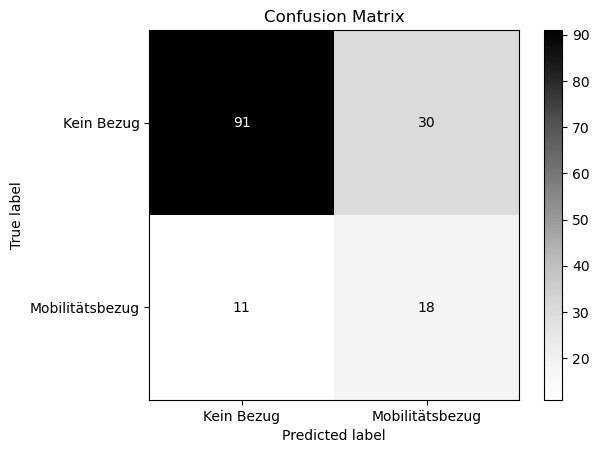

In [5]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Kein Bezug", "Mobilitätsbezug"])
disp.plot(cmap='Greys')
plt.title("Confusion Matrix")
plt.show()